In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn import metrics
import cv2
import gc
import os
import warnings
warnings.filterwarnings('ignore')

# Import PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import resnet50, ResNet50_Weights

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Define paths and constants
path = 'lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
print("Classes:", classes)


Classes: ['lung_aca', 'lung_n', 'lung_scc']


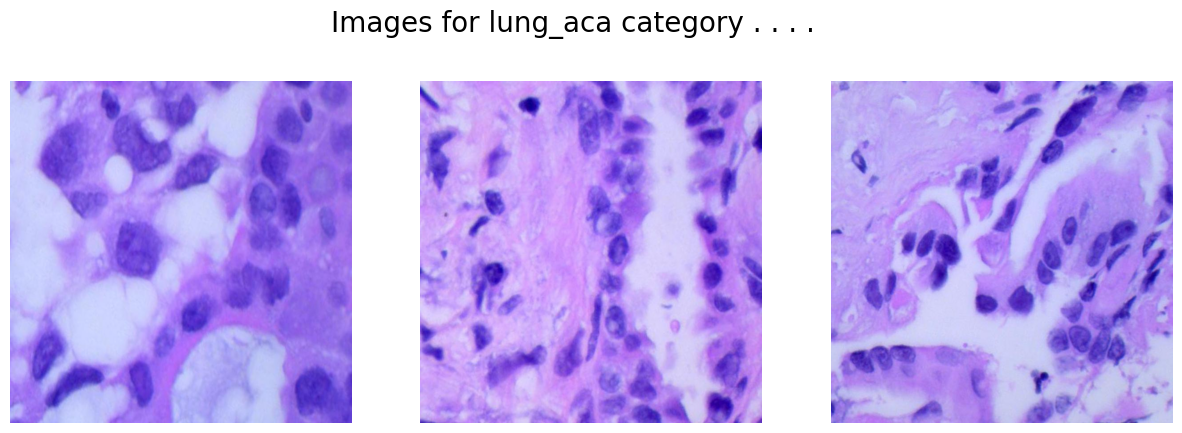

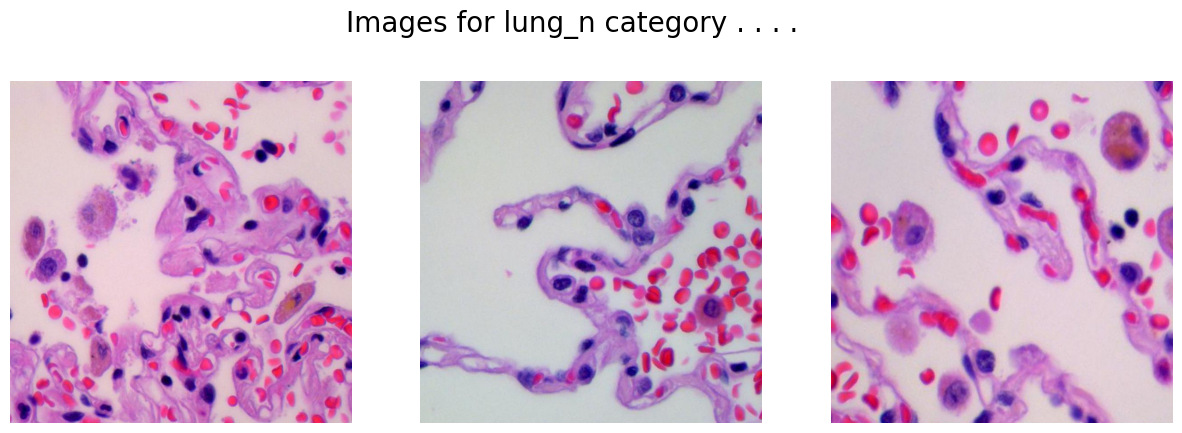

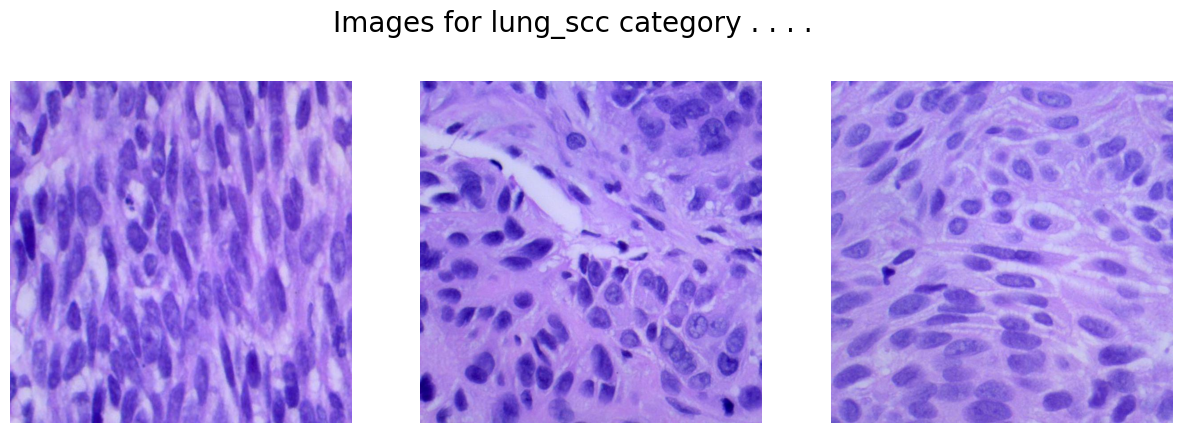

In [4]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()


In [5]:
# Define constants
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [6]:
# Create a custom dataset class
class LungImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [7]:
# Load and preprocess images
X = []
Y = []
for i, cat in enumerate(classes):
    images = glob(f'{path}/{cat}/*.jpeg')
    for image in images:
        img = cv2.imread(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
        Y.append(i)


In [8]:
X = np.asarray(X)
Y = np.asarray(Y)

In [9]:
# Split data
X_train, X_val, Y_train, Y_val = train_test_split( X, Y, test_size=SPLIT, random_state=2022)

In [10]:
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Training samples: 12000, Validation samples: 3000


In [11]:
# Define transformations
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
# Create dataset objects
train_dataset = LungImageDataset(X_train, Y_train, transform=train_transform)
val_dataset = LungImageDataset(X_val, Y_val, transform=val_transform)


In [13]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [14]:
class LungCancerClassifier(nn.Module):
    def __init__(self, num_classes):
        super(LungCancerClassifier, self).__init__()
        # Load pre-trained ResNet50
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
        
        # Freeze base ResNet50 layers
        for param in resnet.parameters():
            param.requires_grad = False
        
        # Get the features from ResNet (everything except final FC layer)
        in_features = resnet.fc.in_features
        modules = list(resnet.children())[:-1]  # Remove the final fc layer
        
        # Create feature extractor using sequential
        self.feature_extractor = nn.Sequential(*modules)
        
        # Create classifier using sequential
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.BatchNorm1d(128),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        # Extract features then classify
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

In [15]:
model = LungCancerClassifier(num_classes=len(classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)


In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        # Ensure labels are long type (required for CrossEntropyLoss)
        labels = labels.long().to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

In [17]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # Ensure labels are long type (required for CrossEntropyLoss)
            labels = labels.long().to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
# Training loop
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0
early_stop_counter = 0
early_stop_patience = 3

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validate
    val_loss, val_acc, val_preds, val_labels = validate_epoch(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    # Update learning rate
    scheduler.step(val_loss)
    
    # Print progress
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    
    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Save the best model
        torch.save(model.state_dict(), 'best_lung_cancer_model.pth')
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    
    if early_stop_counter >= early_stop_patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break
    
    # Stop if accuracy is high enough
    if val_acc > 0.90:
        print("\nValidation accuracy has reached up to 90%, stopping further training.")
        break

Epoch 1/10
Train Loss: 0.1463, Train Acc: 0.9461
Val Loss: 0.1020, Val Acc: 0.9630
Epoch 2/10
Train Loss: 0.0979, Train Acc: 0.9626
Val Loss: 0.0880, Val Acc: 0.9673
Epoch 3/10
Train Loss: 0.0737, Train Acc: 0.9718
Val Loss: 0.0433, Val Acc: 0.9850
Epoch 4/10
Train Loss: 0.0595, Train Acc: 0.9774
Val Loss: 0.0405, Val Acc: 0.9843
Epoch 5/10
Train Loss: 0.0547, Train Acc: 0.9784
Val Loss: 0.0496, Val Acc: 0.9813
Epoch 6/10
Train Loss: 0.0511, Train Acc: 0.9798
Val Loss: 0.0693, Val Acc: 0.9737
Epoch 7/10
Train Loss: 0.0438, Train Acc: 0.9818
Val Loss: 0.0327, Val Acc: 0.9897
Epoch 8/10
Train Loss: 0.0415, Train Acc: 0.9851
Val Loss: 0.0242, Val Acc: 0.9910
Epoch 9/10
Train Loss: 0.0458, Train Acc: 0.9831
Val Loss: 0.0339, Val Acc: 0.9870
Epoch 10/10
Train Loss: 0.0407, Train Acc: 0.9849
Val Loss: 0.0424, Val Acc: 0.9857


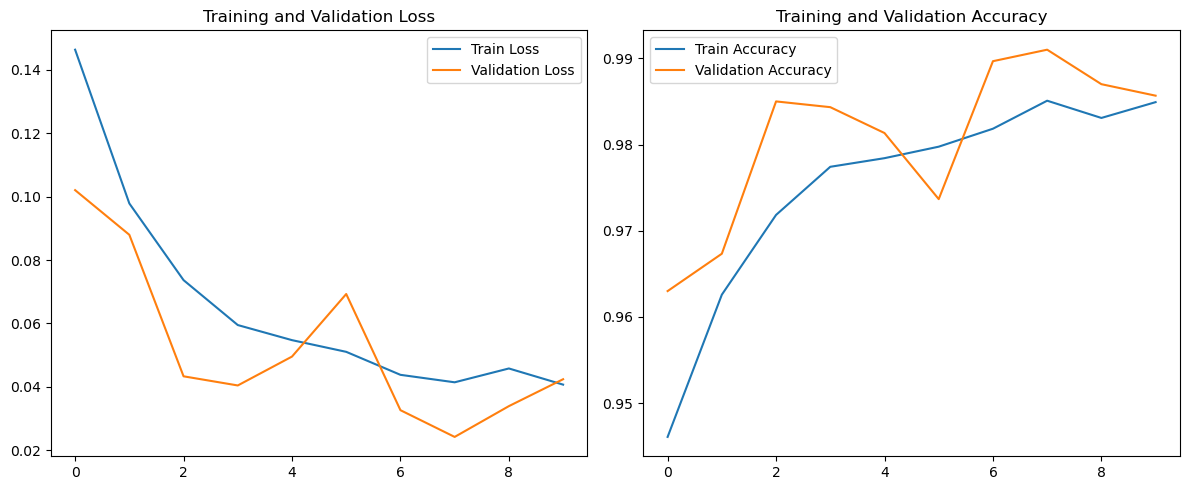

In [19]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Load the best model for evaluation
model.load_state_dict(torch.load('best_lung_cancer_model.pth'))

<All keys matched successfully>

In [21]:
# Final evaluation
_, final_val_acc, final_preds, final_labels = validate_epoch(model, val_loader, criterion, device)
print(f"Final validation accuracy: {final_val_acc:.4f}")

Final validation accuracy: 0.9737


In [22]:
# Confusion matrix
conf_matrix = metrics.confusion_matrix(final_labels, final_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 939    1   47]
 [   1  976    0]
 [  30    0 1006]]


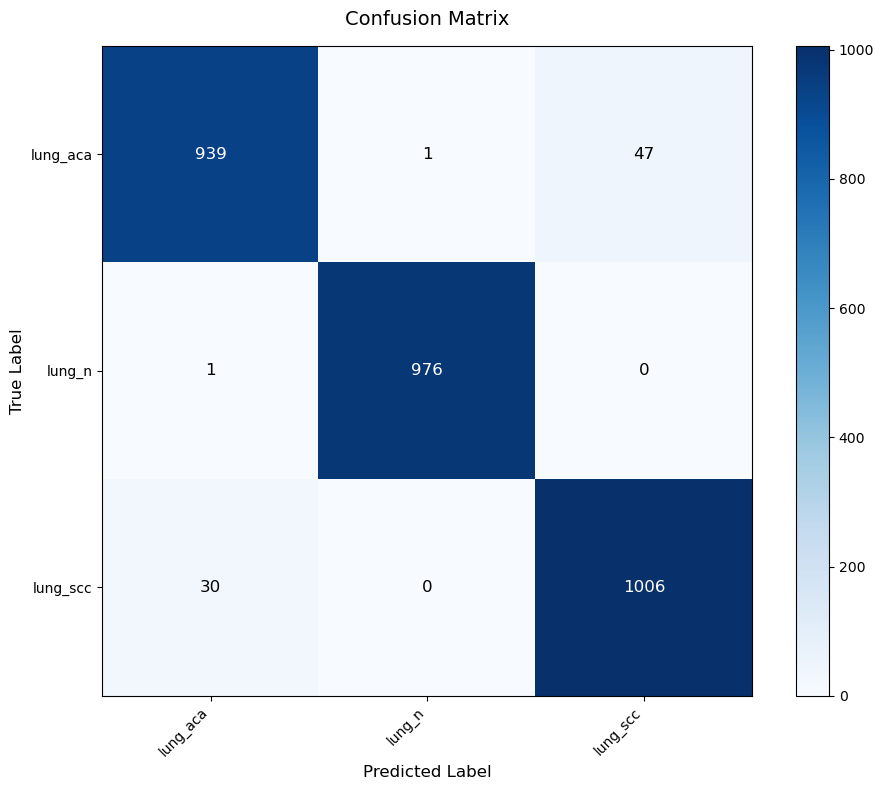

In [23]:
def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 8))
    plt.imshow(conf_matrix, interpolation='nearest', cmap='Blues')
    plt.title('Confusion Matrix', fontsize=14, pad=15)
    plt.colorbar()
    
    # Tick marks and labels
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right')
    plt.yticks(tick_marks, classes)
    
    # Add numbers to the plot
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            plt.text(j, i, format(conf_matrix[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black",
                    fontsize=12)
    
    # Labels and formatting
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function with your confusion matrix
plot_confusion_matrix(conf_matrix, classes)

In [24]:
# Classification report
print("\nClassification Report:")
print(metrics.classification_report(final_labels, final_preds, target_names=classes))


Classification Report:
              precision    recall  f1-score   support

    lung_aca       0.97      0.95      0.96       987
      lung_n       1.00      1.00      1.00       977
    lung_scc       0.96      0.97      0.96      1036

    accuracy                           0.97      3000
   macro avg       0.97      0.97      0.97      3000
weighted avg       0.97      0.97      0.97      3000



In [25]:
#Save model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'classes': classes
}, 'lung_cancer_classifier_pytorch.pth')

print("Model saved to 'lung_cancer_classifier_ResNet50_pytorch.pth'")

Model saved to 'lung_cancer_classifier_ResNet50_pytorch.pth'
